In [4]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ("order_items.csv","order_items")# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Tahera@1313',
    database='ecommerce_2'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = r'C:\Users\Maaz\Desktop\Target company data'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print("NaN values before replacement:\n{}\n".format(df.isnull().sum()))
    

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join(['`{}` {}'.format(col, get_sql_type(df[col].dtype)) for col in df.columns])
    create_table_query = 'CREATE TABLE IF NOT EXISTS `{}` ({})'.format(table_name, columns)
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

# Importing all the libraries which are required in doing project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db=mysql.connector.connect(host='localhost',user='root',password='Tahera@1313',database='ecommerce_2')
cur=db.cursor()

# List all unique cities where customers are located


In [256]:
query=""" select distinct(customer_city) from customers"""
cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.


In [4]:
query="""select count(order_id) as no_of_orders_in_2017 from orders where year(order_purchase_timestamp)=2017"""
cur.execute(query)
data=cur.fetchall()
print("total orders placed in 2017 are",data[0][0])

total orders placed in 2017 are 45101


# Find the total sales per category.


In [257]:
query="""select upper(p.product_category),round(sum(py.payment_value),2) as total_sales from products p join order_items o 
        on p.product_id=o.product_id join payments py on py.order_id=o.order_id group by p.product_category"""
cur.execute(query)
data=cur.fetchall()
data

df=pd.DataFrame(data,columns=["category","sales"])
df


,category,sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,FASHION BAGS AND ACCESSORIES,218158.28
4,BED TABLE BATH,1712553.67
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


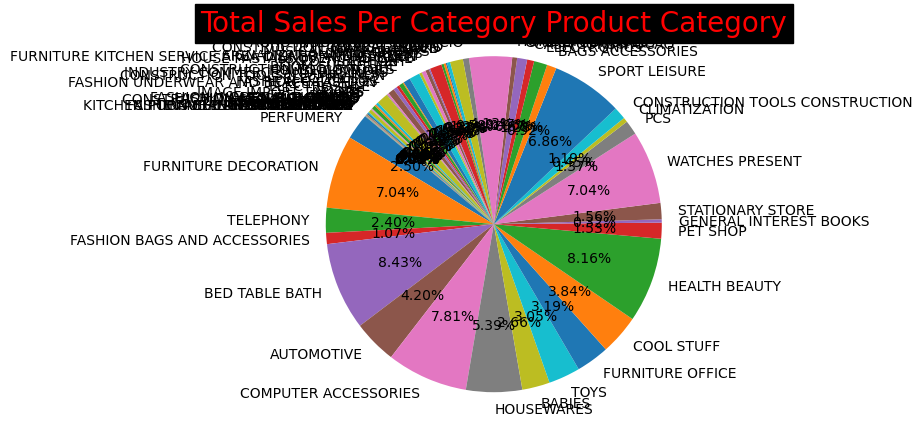

In [262]:
plt.pie(df["sales"],autopct="%.2f%%",labels=df["category"],startangle=140)
plt.title('Total Sales Per Category Product Category',fontsize=20,color="red",backgroundcolor="k")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Calculate the percentage of orders that were paid in installments.


In [254]:
query=""" with cte as (select sum(case when payment_installments >=1 then 1 else 0 end) as total_emi_contracts from payments),
          cte2 as (select count(order_id) as total_contracts from payments)
          select distinct((total_emi_contracts/total_contracts)*100) as percentage_of_emi_orders
           from payments p  join cte c1 on p.order_id=order_id cross join cte2 c2;"""
cur.execute(query)
data=cur.fetchall()
print("percentage of orders that were paid in installments",data[0][0])

percentage of orders that were paid in installments 99.9981


# Count the number of customers from each state


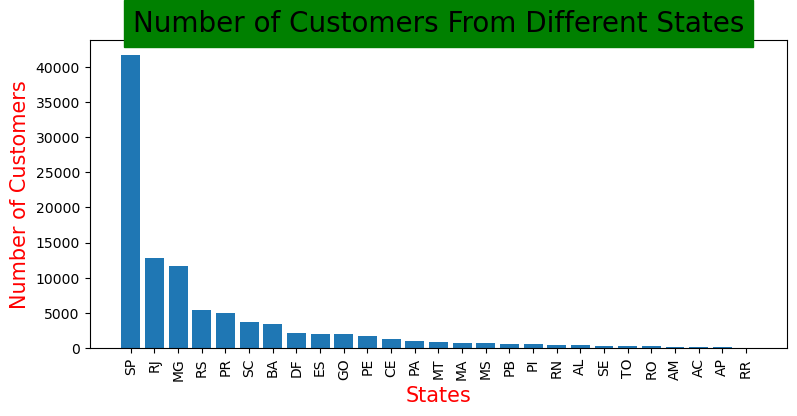

In [250]:
query=""" select count(customer_id) as no_of_customers,customer_state
           from customers group by customer_state"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["no_of_customers","state"])
df=df.sort_values(by="no_of_customers",ascending=False)
plt.figure(figsize=(9,4))
plt.bar(df["state"],df["no_of_customers"])
plt.xticks(rotation=90)
plt.xlabel("States",color="red",fontsize=15)
plt.ylabel("Number of Customers",color="red",fontsize=15)
plt.title("Number of Customers From Different States",backgroundcolor="g",fontsize=20)
plt.show()

# Calculate the number of orders per month in 2018.


      months  total_sales
0       July         6292
1     August         6512
2   February         6728
3       June         6167
4      March         7211
5    January         7269
6        May         6873
7      April         6939
8  September           16
9    October            4


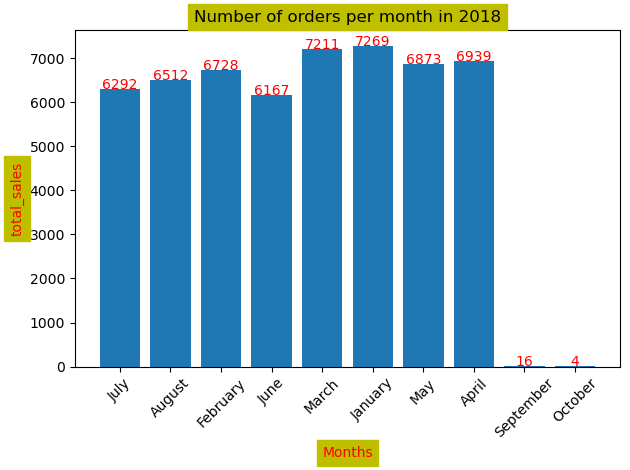

In [25]:
query=""" select monthname(order_purchase_timestamp) as months,count(order_id) as total_orders 
        from orders where year(order_purchase_timestamp)=2018 group by months"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["months","total_sales"])
print(df)
plt.bar(df["months"],df["total_sales"])
plt.xticks(df["months"],rotation=45)
plt.xlabel("Months",color="red",backgroundcolor="y")
plt.ylabel("total_sales",color="red",backgroundcolor="y")
plt.title("Number of orders per month in 2018",color="k",backgroundcolor="y")
for i in range(10):
    plt.annotate(df["total_sales"][i],(df["months"][i],df["total_sales"][i]),ha="center",color="red")
plt.tight_layout()
plt.show()

# Find the average number of products per order, grouped by customer city


In [240]:
query=""" with cte as (select o.order_id,o.customer_id,count(i.order_id) as count_order_id
          from orders o join order_items i on o.order_id=i.order_id group by o.order_id,o.customer_id)
          select c.customer_city,round(avg(c1.count_order_id),2) as average_orders from customers c  cross join cte c1 on 
          c.customer_id=c1.customer_id group by c.customer_city order by average_orders desc"""
cur.execute(query)
data=cur.fetchall()
df1=pd.DataFrame(data,columns=["customer_city","average_orders"])
df1.head(10)

,customer_city,average_orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00
5,morro de sao paulo,4.00
6,cidelandia,4.00
7,picarra,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Calculate the percentage of total revenue contributed by each product category


In [235]:
query=""" with cte as(select round(sum(py.payment_value),2) as total_sales_value from payments py)
select upper(p.product_category) as category,round(sum(py.payment_value),2) as sales, 
round((round(sum(py.payment_value),2)/total_sales_value)*100,2) as percentage_of_total_sales
from products p join order_items o 
on p.product_id=o.product_id join payments py on py.order_id=o.order_id cross join cte c1 group by p.product_category
order by percentage_of_total_sales desc"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["category","sales","percentage_of_total_sales"])
df

,category,sales,percentage_of_total_sales
0,BED TABLE BATH,1712553.67,10.70
1,HEALTH BEAUTY,1657373.12,10.35
2,COMPUTER ACCESSORIES,1585330.45,9.90
3,FURNITURE DECORATION,1430176.39,8.93
4,WATCHES PRESENT,1429216.68,8.93
...,...,...,...
69,HOUSE COMFORT 2,1710.54,0.01
70,CDS MUSIC DVDS,1199.43,0.01
71,PC GAMER,2174.43,0.01
72,FASHION CHILDREN'S CLOTHING,785.67,0.00


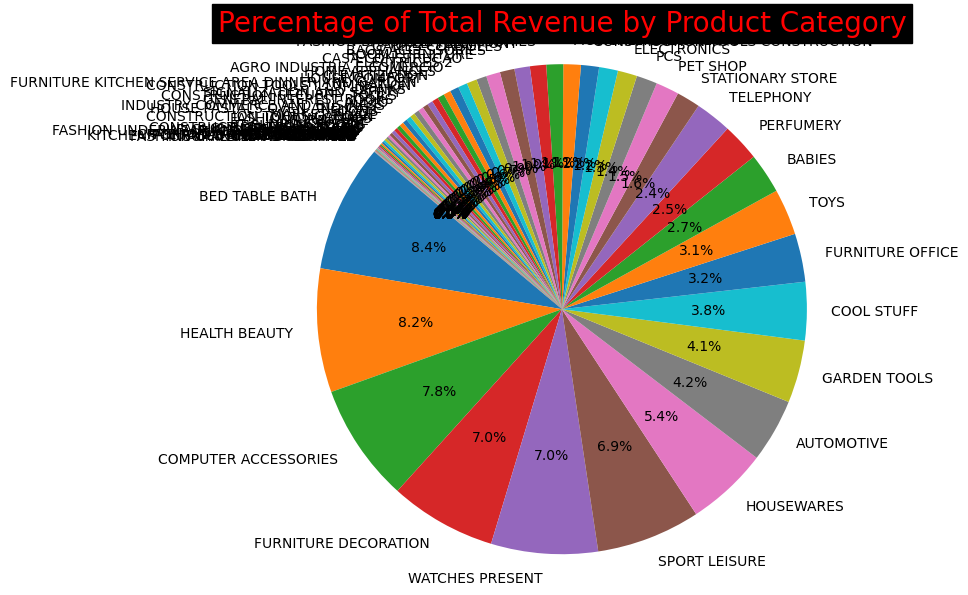

In [238]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.pie(df['percentage_of_total_sales'], labels=df['category'], autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Total Revenue by Product Category',fontsize=20,color="red",backgroundcolor="k")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Identify the correlation between product price and the number of times a product has been purchased


In [226]:
query=""" select p.product_category,round(avg(o.price),2) as product_price,
count(o.product_id)
from order_items o join products p on o.product_id=p.product_id group by p.product_category order by product_price desc"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["category","price","order_count"])
df.head(10)
arr1=df["order_count"]
arr2=df["price"]
a=np.corrcoef([arr1,arr2])
print(a)
print("the correlaeation between price and number of times a product has been purchased",a[0][1])


[[ 1.         -0.10631514]
 [-0.10631514  1.        ]]
the correlaeation between price and number of times a product has been purchased -0.10631514167157564


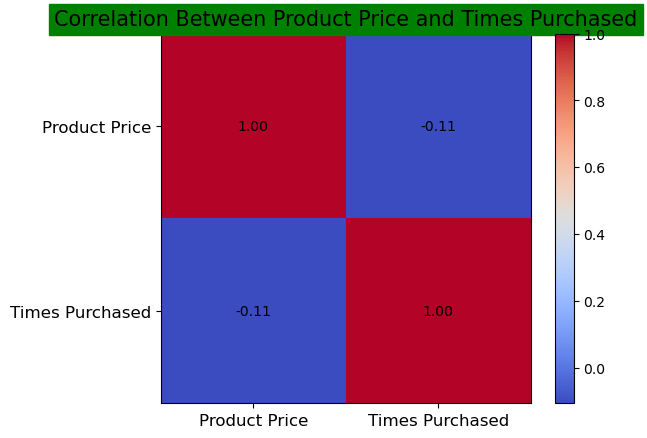

In [233]:
plt.imshow(a,cmap="coolwarm",interpolation="nearest")
plt.colorbar()
for i in range(len(a)):
    for j in range(len(a)):
        plt.text(j,i,f'{a[i, j]:.2f}',ha="center",va="center",color="k")
        
plt.xticks([0, 1], ["Product Price", "Times Purchased"], fontsize=12)
plt.yticks([0, 1], ["Product Price", "Times Purchased"], fontsize=12)
plt.title('Correlation Between Product Price and Times Purchased', fontsize=15,backgroundcolor="green")
plt.show()

# Calculate the total revenue generated by each seller, and rank them by revenue.

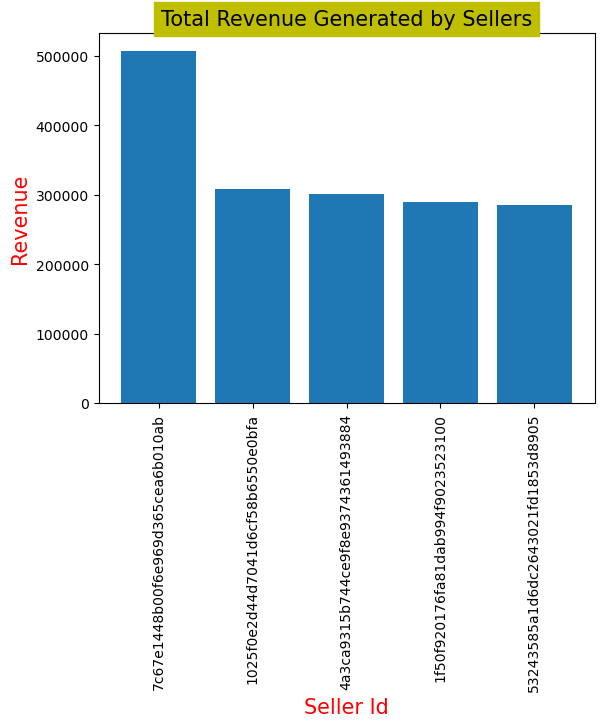

In [221]:
query=""" select a.*,dense_rank() over(order by revenue desc ) as rn from
(select o.seller_id,sum(p.payment_value) as revenue
from order_items o join payments p on o.order_id=p.order_id group by o.seller_id) as a"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["seller_id","revenue","ranking"])
df1=df.head()
plt.bar(df1["seller_id"],df1["revenue"])
plt.xlabel("Seller Id",color="red",fontsize=15)
plt.ylabel("Revenue",color="red",fontsize=15)
plt.xticks(rotation=90)
plt.title("Total Revenue Generated by Sellers",backgroundcolor="y",fontsize=15)
plt.show()

# Calculate the moving average of order values for each customer over their order history

In [209]:
query=""" select a.customer_id,a.order_purchase_timestamp,a.payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row)
as moving_avg from
(select o.customer_id,o.order_purchase_timestamp,p.payment_value as payment
from orders o join payments p on o.order_id=p.order_id) as a"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["customer_id","order_purchase_timestamp","payment","moving_avg"])
df.head(10)

,customer_id,order_purchase_timestamp,payment,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
5,0004164d20a9e969af783496f3408652,2017-04-12 08:35:12,71.80,71.800003
6,000419c5494106c306a97b5635748086,2018-03-02 17:47:40,49.40,49.400002
7,00046a560d407e99b969756e0b10f282,2017-12-18 11:08:30,166.59,166.589996
8,00050bf6e01e69d5c0fd612f1bcfb69c,2017-09-17 16:04:44,85.23,85.230003
9,000598caf2ef4117407665ac33275130,2018-08-11 12:14:35,1255.71,1255.709961


# Calculate the cumulative sales per month for each year

In [190]:
query=""" select a.years,a.months,a.payment,sum(a.payment) over(order by a.years,a.months) as cumsum_sales  from
(select year(o.order_purchase_timestamp) as years,
month(o.order_purchase_timestamp) as months,
round(sum(p.payment_value),2) as payment
from orders o join payments p on o.order_id=p.order_id group by years,months order by years,months) as a"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["years","months","payment","cumsum_sales"])
df

,years,months,payment,cumsum_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


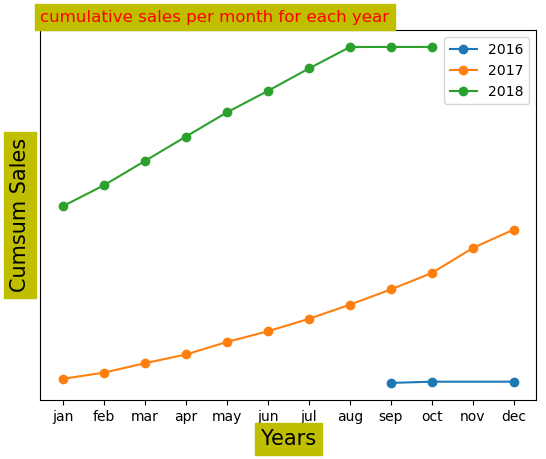

In [208]:
for year in df["years"].unique():
    yearly_data=df[df["years"]==year]
    plt.plot(yearly_data["months"],yearly_data["cumsum_sales"],"o-")
plt.xlabel("Years",fontsize=15,color="k",backgroundcolor="y")
plt.ylabel("Cumsum Sales",fontsize=15,color="k",backgroundcolor="y")
plt.legend(["2016","2017","2018"])
plt.xticks(ticks=range(1,13),labels=["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"])
plt.yticks([])
plt.title("cumulative sales per month for each year",color="r",backgroundcolor="y",loc="left")
plt.show()


# Calculate the year-over-year growth rate of total sales

In [116]:
query="""with cte as (select year(o.order_purchase_timestamp) as years,
         round(sum(i.freight_value+i.price),2) as total_sales
         from order_items i join orders o on i.order_id=o.order_id group by years order by years)
         select c2.years,c2.total_sales,
         lag(c2.total_sales,1) over(order by c2.years) as previous_year,
         ((c2.total_sales-lag(c2.total_sales,1) over(order by c2.years))/lag(c2.total_sales,1) over(order by c2.years))*100 
         as yoy_growth from  cte c2"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["years","Sales","previous_years","yoy_%_growth"])
df

,years,Sales,previous_years,yoy_%_growth
0,2016,57183.21,NaN,NaN
1,2017,7142672.43,57183.21,12390.856022
2,2018,8643697.60,7142672.43,21.014896


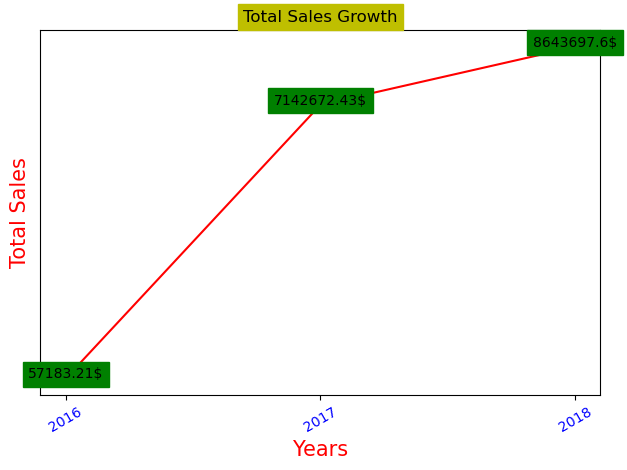

In [178]:
plt.plot(df["years"],df["Sales"],"o-r")
plt.xticks(df["years"],labels=["2016","2017","2018"],color="blue",rotation=30)
for i in range(len(df["years"])):
    plt.annotate(str(df["Sales"][i])+str("$"),(df["years"][i],df["Sales"][i]),ha="center",backgroundcolor="green")
plt.xlabel("Years",color="red",fontsize=15)
plt.ylabel("Total Sales",color="red",fontsize=15)
plt.title("Total Sales Growth",backgroundcolor="y")
plt.yticks([])
plt.tight_layout()
plt.show()

# Calculate the retention rate of customers, defined as the percentage of customers who make another  purchase within 6 months of their first purchase

In [54]:
query="""with cte as (select c.customer_id,min(o.order_purchase_timestamp) as first_order
        from customers c join orders o on c.customer_id=o.customer_id group by c.customer_id)
        select c1.customer_id,count(distinct o.order_purchase_timestamp) from cte c1 join orders o 
        on o.customer_id=c1.customer_id and o.order_purchase_timestamp> first_order 
        and o.order_purchase_timestamp<date_add(first_order,interval 6 month) group by c1.customer_id"""

cur.execute(query)
data=cur.fetchall()
print(data)
print("it is coming none because we don't have any customers who have purchased again within 6 months of there first purcahse")

[]
it is coming none because we don't have any customers who have purchased again within 6 months of there first purcahse


# Identify the top 3 customers who spent the most money in each year

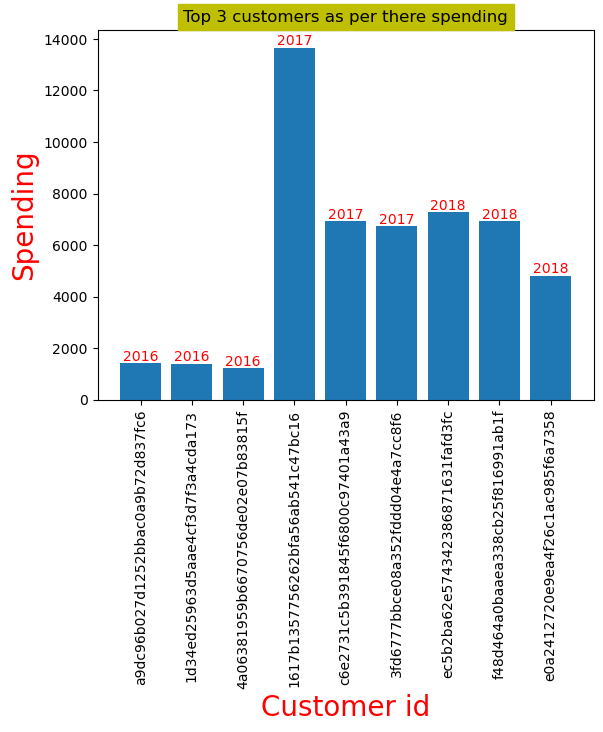

In [106]:
query=""" select a.years,a.customer_id,a.payments,a.ranking from
(select year(o.order_purchase_timestamp) as years,o.customer_id,round(sum(p.payment_value),2) as payments,
dense_rank() over(partition by year(o.order_purchase_timestamp) order by sum(p.payment_value) desc) as ranking
from payments p join orders o on p.order_id=o.order_id
group by year(o.order_purchase_timestamp),o.customer_id,o.order_id) as a
where a.ranking <=3"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["years","id","payment","rank"])
line=plt.bar(df["id"],df["payment"])
plt.xticks(rotation=90)
for i in range(len(df["years"])):
    plt.annotate(df["years"][i],(df["id"][i],df["payment"][i]+100),ha="center",color="red")
plt.title("Top 3 customers as per there spending",backgroundcolor="y")
plt.xlabel("Customer id",fontsize=20,color="red")
plt.ylabel("Spending",fontsize=20,color="red")
plt.show()